# To-do: 
- Based on the above, we need to remove the names of the co-hosts from the list of words that show up!
- string cleaning

## Load in Data

### Read in the total list of data files

In [1]:
#import libraries
import glob 
import os
import matplotlib.pyplot as plt

#step 1: get a list of file names to read into the dataset
repo_path = os.path.dirname(os.getcwd()) #get the correct file path 
rm_paths = glob.glob(repo_path + "/data/01-raw/rachel_maddow/*.txt") #the paths for the rachel maddow transcript files
ac_paths = glob.glob(repo_path + "/data/01-raw/anderson_cooper/*.txt") #the paths for the anderson cooper transcript files

all_liberal_files = rm_paths + ac_paths


### Read in text of transcript files

In [2]:
raw_text = [] #create a container to hold the datafiles 

#step 2: read in each transcript as its own string and append to the list of raw documents
for transcript in all_liberal_files:
    text = open(transcript, encoding='utf-8').read()
    raw_text.append(text)


In [3]:
print("Our liberal news corpus consists of {:,} total transcripts, sourced from Anderson Cooper 360 and the Rachel Maddow Show.".format(len(raw_text)))

Our liberal news corpus consists of 1,008 total transcripts, sourced from Anderson Cooper 360 and the Rachel Maddow Show.


## Data Pre-Processing

### Spacy Implementation & Removal of Stop Words 
This analysis is useful if we want more control over the corpus of stop words that are used in our analysis

In [4]:
#Compare spacy implemtation to the sklearn #loads spacy and turns off some aspects 
# import spacy
# nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])


## Word- Frequency Analysis

### Use CountVectorizer to get the unique vocabulary list and eliminate stop words



In [5]:
#import the required package for the tfidf vector
from sklearn.feature_extraction.text import CountVectorizer

#step 1: set up the tfidf vectorizer
vectorizer = CountVectorizer(min_df=50, stop_words="english", max_df=0.8) #update/justify using these settings 
 
#step 2: apply the vectorizer to the corpus of documents (& store in document matrix X )
X = vectorizer.fit(raw_text) #should we use just .fit or .fit_transform? The latter actually results in the creation of a matrix object (where # of cols = # of words in the vocab)

#step 3: print out the vocabulary found by the tfid object
print("There are {:,} unique words in the vocabulary.".format(len(X.vocabulary_)))

There are 4,992 unique words in the vocabulary.


In [6]:
#check to see if "covid" is in the dictionary
vocab = X.vocabulary_

#vocab['covid'] #results in an index of 1197) 
#Note: this is NOT equivalent to the number of times covid appears in the documents
# the number below is solely an index value

In [7]:
#check to see if "coronavirus" is in the dictionary - return index

vocab['coronavirus']

1098

### Get a Word-Frequency Table from CountVectorizer
   Note: need to double-check how the counts are arrived at - is it by document or number of occurences in a given document?

In [8]:
X_transformed = vectorizer.fit_transform(raw_text)


In [9]:
array_of_words = vectorizer.get_feature_names_out()
array_of_words

array(['00', '01', '02', ..., 'zero', 'zone', 'zoom'], dtype=object)

In [10]:
array_of_counts = X_transformed.toarray().sum(axis=0) #sum the number of occurences of a word across the entire liberal corpus
array_of_counts

array([3500,  413,  396, ...,  483,  190,   81], dtype=int64)

In [11]:
word_frequency_dictionary = dict(zip(array_of_words,array_of_counts))

### Plot the Top 10 Most Frequency Occuring Words

In [12]:
from operator import itemgetter

#set the number of top words to see
num_top_words = 10

top_10_words = dict(sorted(word_frequency_dictionary.items(), key = itemgetter(1), reverse = True)[:num_top_words])

print(top_10_words)


{'cooper': 19988, 'maddow': 8800, 'cnn': 8641, 'anderson': 6995, 'republicans': 6014, 'dr': 5812, 'police': 5547, 'health': 5397, 'court': 5303, 'vote': 5294}


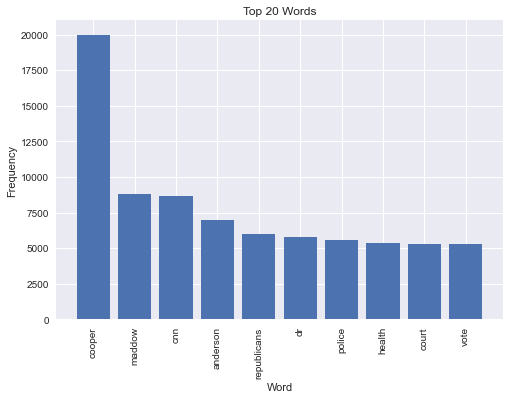

In [13]:
plt.style.use('seaborn')  

x = top_10_words.keys()
y = top_10_words.values()
plt.bar(x,y)
plt.xlabel('Word')
plt.xticks(rotation='vertical')
plt.ylabel('Frequency')
plt.title('Top 20 Words')

plt.show()

In [14]:
# total_unique_words = X.vocabulary_ #, key=lambda d: d[1]) 

# total_unique_words
#X.vocabulary_

## Co-Occurence Analysis

- Need to do string cleaning. 
- For now, appearance anywhere in a transcript increases count by 1.

In [15]:
# import packages
from collections import Counter
import spacy
import numpy as np

In [16]:
# instantiate nlp
nlp = spacy.load('en_core_web_sm', disable = ['parser'])

In [17]:
# need to do some pre-processing/string cleaning*****
# warning: takes a while
liberal_nlp = [nlp(text) for text in raw_text]

In [18]:
# num transcripts
num_transcripts = len(liberal_nlp)

In [19]:
# see full lemma set - identify how covid is named
lemma_set = set(token.lemma_.lower() for transcript in liberal_nlp for token in transcript)
len(lemma_set)

56824

In [27]:
# covid_terms
covid_terms = ['coronavirus', 'covid', 'covid-19']

lemma_set.intersection(set(covid_terms))

{'coronavirus', 'covid', 'covid-19'}

In [28]:
# counters
lemma_counts = Counter()
co_occur_counts = Counter()
covid_count = 0

# for each transcript, add unique lemmas to counter
# increase co-occurrence and covid counter if covid terms overlap lemma set
for transcript in liberal_nlp:
    lemmas = {token.lemma_.lower() for token in transcript}
    lemma_counts.update(lemmas)
    if not lemmas.isdisjoint(set(covid_terms)):
        co_occur_counts.update(lemmas)
        covid_count += 1

# P(covid)
covid_ratio = covid_count / num_transcripts # constant

# calculate PMI only for words that co-occur (do not care about others)
pmi = list()
for lemma, count in co_occur_counts.items():
    
    lemma_ratio = lemma_counts[lemma] / num_transcripts # P(lemma)
    co_ratio = co_occur_counts[lemma] / num_transcripts # P(covid, lemma)
    
    pmi += [(lemma, 
             np.log2(co_ratio / (covid_ratio * lemma_ratio)))]

# sort list of tuples by pmi, descending
pmi_sort = sorted(pmi, key = lambda x: x[1], reverse = True)

In [29]:
# see top 100 pmi values (note ties)
pmi_sort[0:100]

[('2,200', 0.21240833276382595),
 ('ppe', 0.21240833276382595),
 ('birx', 0.21240833276382595),
 ('coronavirus', 0.21240833276382595),
 ('intubate', 0.21240833276382595),
 ('visualization', 0.21240833276382595),
 ('gown', 0.21240833276382595),
 ('retailer', 0.21240833276382595),
 ('alleviate', 0.21240833276382595),
 ('240,000', 0.21240833276382595),
 ('javits', 0.21240833276382595),
 ('gambit', 0.21240833276382595),
 ('inequity', 0.21240833276382595),
 ('garcetti', 0.21240833276382595),
 ('n95', 0.21240833276382595),
 ('destiny', 0.21240833276382595),
 ('skyrocket', 0.21240833276382595),
 ('reeves', 0.21240833276382595),
 ('ebola', 0.21240833276382595),
 ('patchwork', 0.21240833276382595),
 ('inslee', 0.21240833276382595),
 ('nationalize', 0.21240833276382595),
 ('caseload', 0.21240833276382595),
 ('steeply', 0.21240833276382595),
 ('merkel', 0.21240833276382595),
 ('tolerance', 0.21240833276382595),
 ('lizard', 0.21240833276382595),
 ('metaphor', 0.21240833276382595),
 ('tampa', 0.212

## Topic Modeling

## Sentiment Analysis